In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
import numpy as np, h5py
from scipy import stats, special, linalg
import healpy as hp
import emcee, tqdm, corner
import scipy.optimize
from multiprocessing import Pool

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

In [156]:
def expit(x):
    return np.exp(x)/(1+np.exp(x))

## Data

In [25]:
data = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    _magnbins = np.max(np.array(list(hf.keys()))[:-1].astype(int))
    for key in ['n','k']: data[key] = np.zeros(_magnbins+1)
    for i in range(_magnbins+1):
        for key in ['n','k']: data[key][i]=np.sum(hf[str(i)][key][...])
    data['magbins'] = hf['magval'][...]

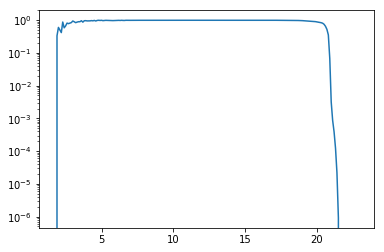

In [27]:
plt.plot(data['magbins'], data['k']/data['n'])
plt.yscale('log')

## Gaussian process prior

In [110]:
def mean_func(x):
    return np.zeros(x.shape)

def cov_expsq(xx,s=1,l=1,noise=0.01,square=False):
    
    xa, xb = xx
    cov =  s**2 * np.exp(-0.5 * (xa-xb)**2 / l**2)
    if square: cov += np.eye(xa.shape[0])*noise**2
        
    return cov

In [146]:
def gp_prior_logl(x, y, kernel, hyper):

    KXX = kernel(np.meshgrid(x, x), square=True, **hyper)
    KXX_inv = np.linalg.inv(KXX)
    
    exponent = 0.5*np.sum(np.matmul(y, KXX_inv) * y)
    logL = -0.5*np.log(np.linalg.det(KXX)) - exponent
    
    return logL

In [112]:
y = np.random.normal(0,1,len(data['magbins']))

In [113]:
gp_prior_logl(data['magbins'], y, cov_expsq, {'l':1,'s':1e-5,'noise':1})

-223.21695376549656

In [182]:
def nloglike_grad(params, k, n):
    
    exp_x = np.exp(x)
    logl = np.sum( k*x - n*np.log(1+exp_x) )
    
    grad_norm = k - n*exp_x/(1+exp_x)
    grad = np.sum(grad_norm[:,None] * Ylm_grid[hpx], axis=1)
    
    return -logl, -grad

def nloglike(params,G,k,n):
    
    x = params[2:].copy()
    
    exp_x = np.exp(x)
    logl = np.sum( k*x - n*np.log(1+exp_x) )
    
    logprior = gp_prior_logl(G, x, cov_expsq, {'l':params[0],'s':params[1],'noise':1})
    
    if np.isinf(logl+logprior):
        return 1e20
    
    return -(logl+logprior)

In [183]:
p0=np.hstack((np.random.rand(2), np.random.normal(0.,1., size=len(data['magbins']))))
nloglike(p0, data['magbins'],data['k'],data['n'])

1703571923.6632588

In [184]:
result = scipy.optimize.minimize(nloglike, p0, method='Powell', 
                                 args=(data['magbins'],data['k'],data['n']))
result

   direc: array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
     fun: 502470544.2123474
 message: 'Optimization terminated successfully.'
    nfev: 5065
     nit: 2
  status: 0
 success: True
       x: array([ 5.63206271e+00,  1.29644733e+03, -1.16925014e+00, -1.13508518e+00,
       -5.82560064e-01,  7.37204812e-02, -5.85048664e-02, -2.39541393e-01,
        1.15549058e+00,  3.60345719e-01,  6.76609220e-01,  1.28415151e+00,
        1.22272420e+00,  1.42229752e+00,  1.58550572e+00,  2.20988952e+00,
        2.00845571e+00,  1.67662076e+00,  1.93220242e+00,  2.14889282e+00,
        2.17133507e+00,  2.94323608e+00,  1.96944526e+00,  3.01750142e+00,
        3.13652216e+00,  2.86992916e+00,  2.94799392e+00,  2.97141810e+00,
        3.33622982e+00,  3.04097609e+00,  3.75009246e+00,  2.84553462e+00,
       

In [185]:
result['x'][:2]

array([   5.63206271, 1296.44732761])

Text(0.5, 0, '$G$')

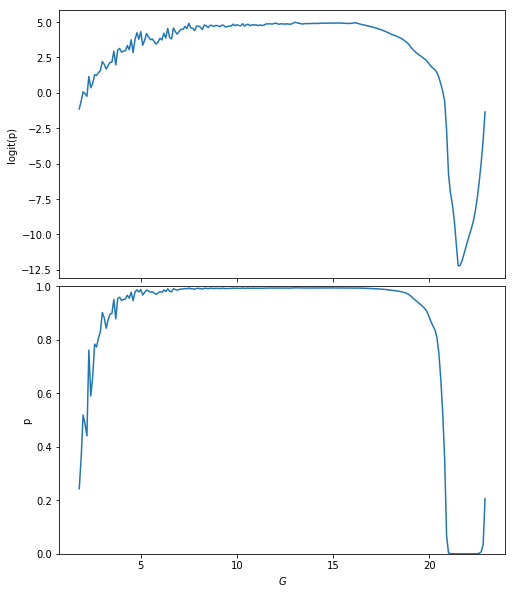

In [186]:
fig, ax = plt.subplots(2,1,figsize=(8,10), sharex=True)

plt.sca(ax[0])
plt.plot(data['magbins'][1:],result['x'][3:])
plt.ylabel('logit(p)')

plt.sca(ax[1])
plt.plot(data['magbins'][1:],expit(result['x'][3:]))
plt.ylim(0,1); 
plt.subplots_adjust(hspace=0.03)
plt.ylabel('p')
plt.xlabel(r'$G$')

In [187]:
%timeit nloglike(p0, data['magbins'],data['k'],data['n'])

12.1 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [218]:
450*0.012

5.4

In [188]:
def ll(params):
    return -nloglike(params,data['magbins'],data['k'],data['n'])

In [217]:
ndim=result['x'].shape[0]; nwalker=450; nstep=200
p0_walkers = np.random.normal(result['x'], 0.1, size=(nwalker, ndim))

In [212]:
for ii in range(nwalker): print(ll(p0_walkers[ii]))

-503088380.4123382
-503643427.71881217
-503284382.08450943
-503381212.0746747
-503871166.72906005
-502964620.8604971
-502998060.55658823
-503559695.2577534
-503056699.02810246
-502936655.7906903
-503212688.5105845
-503473973.9860273
-503056444.5449844
-503707174.52554107
-504014557.2146287
-502981375.0159774
-503535683.7626132
-502903223.2100204
-503065773.7057228
-503003425.8239682
-502864490.0202863
-502910503.63885045
-503291148.6773447
-503522985.8436455
-502852880.52800936
-503218061.1730468
-502896925.78409696
-503088342.1157328
-502937782.9421214
-503668238.0159656
-503417917.19039506
-503291701.22150373
-503907531.83723134
-503508372.4486355
-503796509.10624635
-502931556.53666013
-502955684.68485904
-503335306.2539275
-503106337.80910605
-503020805.71436775
-503117525.48688644
-503286784.5995061
-502955779.0396132
-503237528.0357885
-503344138.36803555
-502972374.3331209
-503393659.8687828
-503279010.18502593
-503347529.756146
-503341974.9573583
-502801169.95957446
-504128593.

In [220]:
sampler = emcee.EnsembleSampler(nwalker, ndim, ll)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

In [219]:
ncores=2
with Pool(ncores) as pool:
    sampler = emcee.EnsembleSampler(nwalker, ndim, ll, pool=pool)
    for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
        pass

emcee: Exception while calling your likelihood function:


KeyboardInterrupt: 